In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from pmdarima import auto_arima

In [33]:
from statsmodels.stats.diagnostic import het_white

In [5]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")

In [6]:
robberies_in_boston['Month'] = pd.to_datetime(robberies_in_boston['Month'])
robberies_in_boston.set_index('Month', inplace=True)

In [8]:
robberies_in_boston.head()

,Count
Month,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43


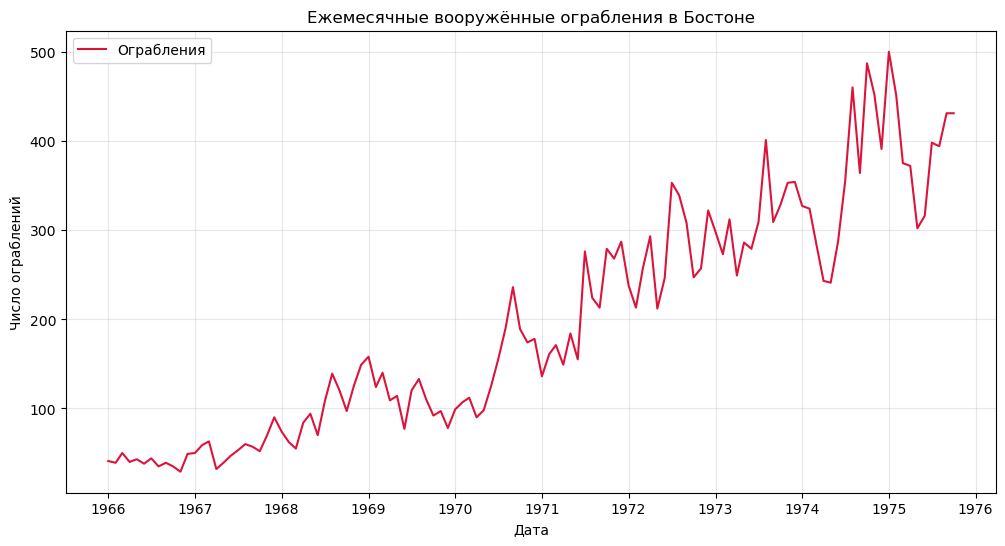

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(robberies_in_boston['Count'], label='Ограбления', color='crimson')
plt.title('Ежемесячные вооружённые ограбления в Бостоне')
plt.xlabel('Дата')
plt.ylabel('Число ограблений')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [20]:
def check_stationarity(series, title="Ряд"):
    result = adfuller(series)
    print(f"{title}:")
    print(f"  ADF-статистика: {result[0]:.4f}")
    print(f"  p-значение: {result[1]:.4f}")
    if result[1] < 0.05:
        print("  → Ряд стационарен\n")
    else:
        print("  → Ряд нестационарен\n")

check_stationarity(robberies_in_boston['Count'], "Исходный ряд")

Исходный ряд:
  ADF-статистика: 1.0011
  p-значение: 0.9943
  → Ряд нестационарен



In [22]:
robberies_diff = robberies_in_boston['Count'].diff().dropna()

result_diff = adfuller(robberies_diff)
print(f"ADF после дифференцирования: {result_diff[0]:.4f}")
print(f"p-значение: {result_diff[1]:.4f}")
check_stationarity(robberies_diff, "Дифферинцированный ряд")

ADF после дифференцирования: -7.4286
p-значение: 0.0000
Дифферинцированный ряд:
  ADF-статистика: -7.4286
  p-значение: 0.0000
  → Ряд стационарен



In [17]:
# Автоподборка модели
arima_model = auto_arima(
    robberies_in_boston['Count'],
    start_p=0, max_p=3,      # диапазон для p
    start_q=0, max_q=3,      # диапазон для q
    d=None,                 # auto-определение d (через KPSS или ADF)
    seasonal=False,          # нет сезонности (для простоты)
    stepwise=True,           # пошаговый поиск (быстрее)
    suppress_warnings=True,
    error_action='ignore',
    trace=True               # вывод процесса подбора
)

print("\nОптимальная модель ARIMA:")
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1205.224, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1199.151, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1195.266, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1203.994, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1189.945, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1193.607, Time=0.66 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1191.444, Time=0.73 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1193.465, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1194.725, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 4.891 seconds

Оптимальная модель ARIMA:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  118
Model:               SARIMAX(0, 1, 2)   

In [36]:
exog = np.column_stack([
    np.ones(len(residuals)),  # константа
    residuals,               # остатки
    residuals**2              # квадраты остатков
])

# Шаг 2. Выполняем тест Уайта
white_test = het_white(residuals**2, exog)

# Шаг 3. Выводим результаты
print("\nТест Уайта на гетероскедастичность:")
print(f"  Статистика: {white_test[0]:.4f}")
print(f"  p‑значение: {white_test[1]:.4f}")
print(f"  Критические значения (1%, 5%, 10%): {white_test[2]}")

if white_test[1] < 0.05:
    print("→ Отвергаем H₀: есть гетероскедастичность. Возможно, нужен GARCH.")
else:
    print("→ Не отвергаем H₀: нет значимых признаков гетероскедастичности. GARCH, вероятно, не требуется.")


Тест Уайта на гетероскедастичность:
  Статистика: 118.0000
  p‑значение: 0.0000
  Критические значения (1%, 5%, 10%): 3.820441541571609e+32
→ Отвергаем H₀: есть гетероскедастичность. Возможно, нужен GARCH.


In [37]:
# Модель GARCH(1,1) для остатков
garch_model = arch_model(
    residuals,
    vol='Garch',
    p=1, q=1,
    dist='Normal'
)
garch_fitted = garch_model.fit(update_freq=5, disp='off')

print("Модель GARCH(1,1):")
print(garch_fitted.summary())

Модель GARCH(1,1):
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -578.312
Distribution:                  Normal   AIC:                           1164.62
Method:            Maximum Likelihood   BIC:                           1175.71
                                        No. Observations:                  118
Date:                Sun, Feb 15 2026   Df Residuals:                      117
Time:                        18:55:39   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -2.9077      2.714     -1.071      0.

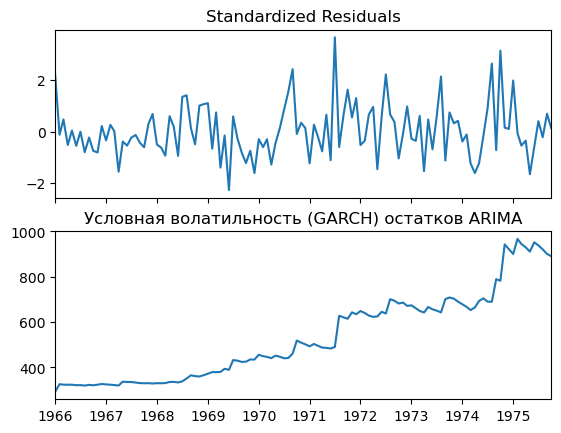

In [38]:
fig = garch_fitted.plot(annualize='D')
plt.title('Условная волатильность (GARCH) остатков ARIMA')
plt.show()

C:\Users\svshi\AppData\Local\Temp\ipykernel_7236\640157582.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=robberies_in_boston.index[-1], periods=13, freq='M')[1:],
C:\Users\svshi\AppData\Local\Temp\ipykernel_7236\640157582.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=robberies_in_boston.index[-1], periods=13, freq='M')[1:],


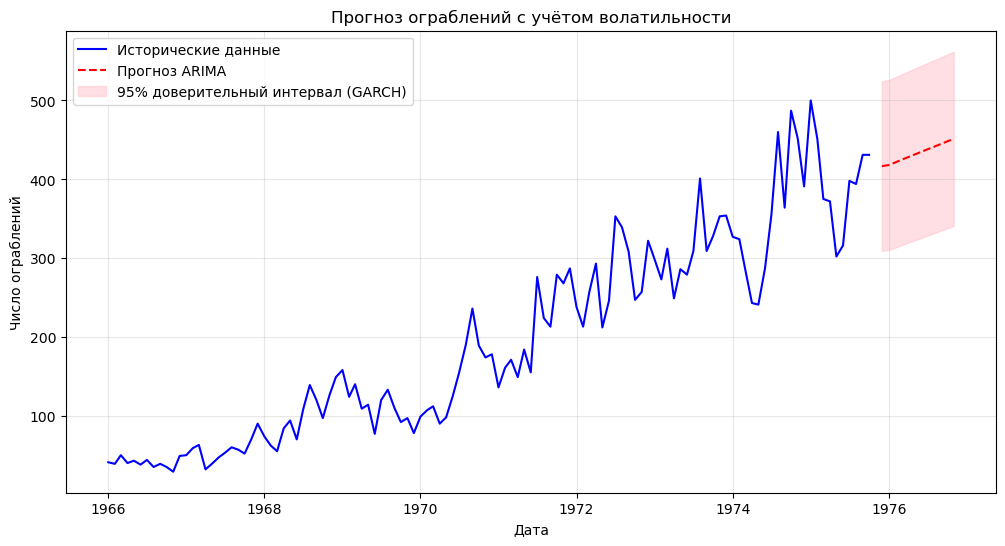

In [40]:
# Прогноз ARIMA на 12 месяцев
arima_forecast = arima_model.predict(n_periods=12)

# Прогноз волатильности через GARCH (упрощённо)
garch_forecast = garch_fitted.forecast(horizon=12)

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(robberies_in_boston.index, robberies_in_boston['Count'], 
         label='Исторические данные', color='blue')
plt.plot(pd.date_range(start=robberies_in_boston.index[-1], periods=13, freq='M')[1:],
         arima_forecast, label='Прогноз ARIMA', color='red', linestyle='--')
plt.fill_between(
    pd.date_range(start=robberies_in_boston.index[-1], periods=13, freq='M')[1:],
    arima_forecast - 1.96 * np.sqrt(garch_forecast.variance.values[-1]),
    arima_forecast + 1.96 * np.sqrt(garch_forecast.variance.values[-1]),
    color='pink', alpha=0.5, label='95% доверительный интервал (GARCH)'
)
plt.title('Прогноз ограблений с учётом волатильности')
plt.xlabel('Дата')
plt.ylabel('Число ограблений')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()